# Step 4.2: Visualizing station clustering

__Step goals:__ Visualize obtained station clusters of over time and space.

__Step overview:__
1. Load the data;
2. Visualize clusters as set of time-series data;
3. Visualize station clusters on map;
4. Explore obtained clustering parameters;
5. Visualize distance between stations by cluster.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
from tqdm import tqdm
from haversine import haversine

from src.visualization.visualize import plot_counts, plot_sample_stations
plt.style.use('science')

In [4]:
# Increase font size
font = {'size' : 12}
matplotlib.rc('font', **font)

## 1. Load the data

In [3]:
data_type = 'entry'

gdf = gpd.read_file(f'../data/interim/counts/{data_type}_station.json')
gdf = gdf.rename({'station' : 'station_name'}, axis=1)

# !!!: The sorting is essential to match labels with stations since the clustering was done on sorted data
gdf = gdf.sort_values('station_name').reset_index(drop=True)

n_components = 6
labels = np.load(f"../data/interim/gmm/stations/labels_{data_type}.npy", allow_pickle=True)[()][n_components]

print(f'Selected number of clusters : {n_components}')

Selected number of clusters : 6


In [4]:
# Assign labels to the stations
gdf['label'] = labels

# Create "meaningful" names for the labels
gdf['label_name'] = gdf['label']

label_names = ["Inner residential", "Polycentre", "CBD", "Mixed commuting", "Outer residential", "Potential feeder"]
# label_names = ["Mixed commuting", "CBD", "Potential feeder", "Inner residential", "Outer residential", "Polycenter"]

label_ids = [_ for _ in range(0, n_components)]

print(f'Cluster names are : {label_names}')

# Rename ids with names
gdf['label_name'].replace({0 : 'Inner residential', 1 : 'Polycentre', 
                           2 : 'CBD', 3 : 'Mixed commuting',
                           4 : 'Outer residential', 5 : 'Potential feeder'},
                           inplace=True)

Cluster names are : ['Inner residential', 'Polycentre', 'CBD', 'Mixed commuting', 'Outer residential', 'Potential feeder']


## 2. Plot stations clusters as time series

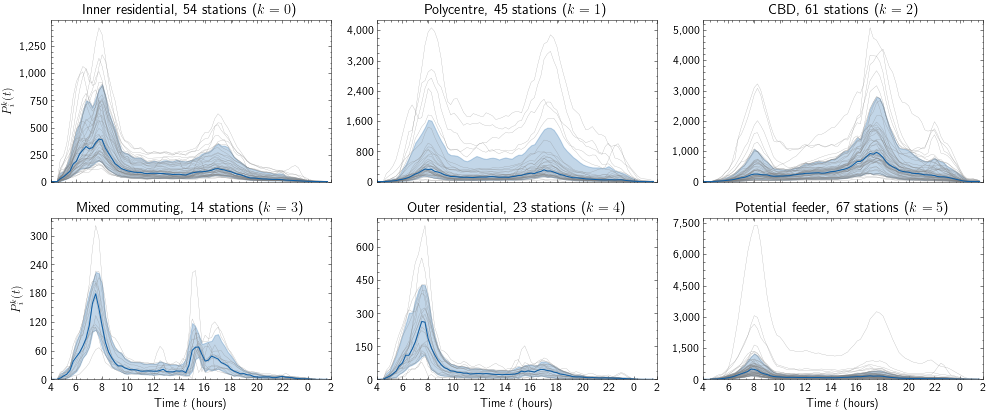

In [52]:
plot_counts(gdf, labels, n_components, label_names=label_names, plot_median=True, sharex=True, savefig=True, figsize=(14,6))

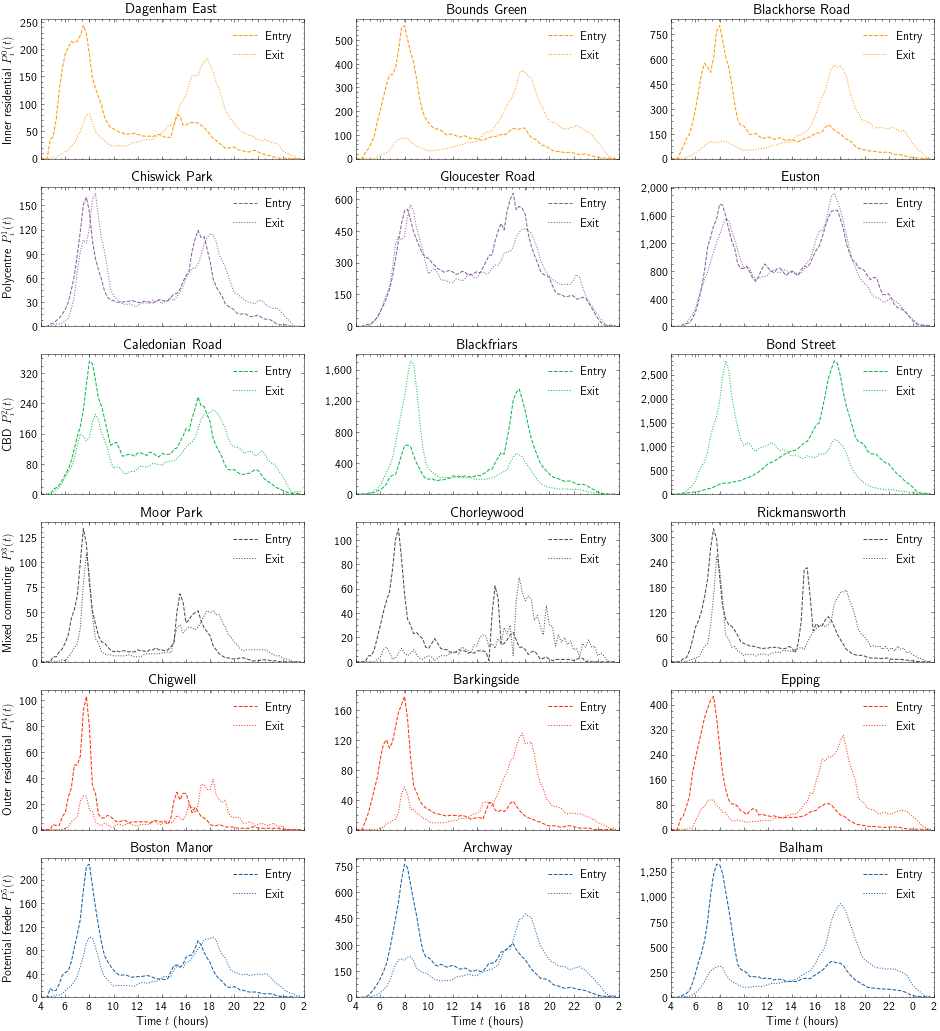

In [13]:
plot_sample_stations(gdf, figsize=(16,18), sharex=True, sharey=False, savefig=False)

## 3. Plot station clusters as map

In [6]:
# Add lat and lon collumns for plotting with Plotly
lon = [point.x for point in gdf['geometry'].tolist()]
lat = [point.y for point in gdf['geometry'].tolist()]
gdf['lat'] = lat
gdf['lon'] = lon

# Save resulting data frame for reusage
gdf.to_file('../data/interim/counts/entry_station_cluster.json', driver='GeoJSON')

In [88]:
# Define API Key
api_key = ""

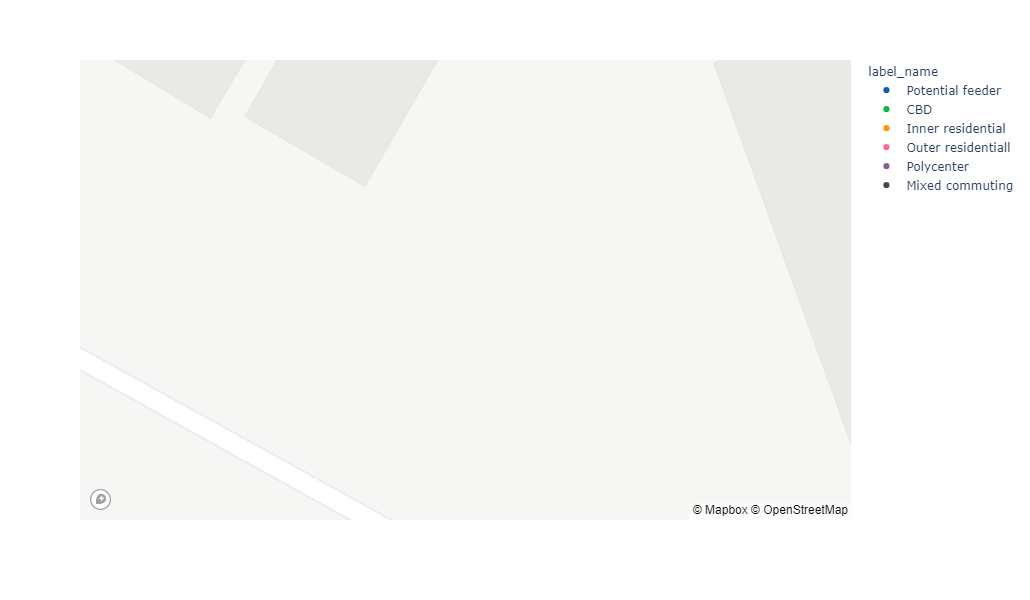

In [89]:
px.set_mapbox_access_token(api_key)
fig = px.scatter_mapbox(gdf, lat="lat", lon="lon", color="label_name", color_discrete_map={
    "Outer residential": "#FF2C00",
    "CBD": "#00B945",
    "Polycenter": "#845B97",
    "Inner residential": "#FF9500",
    "Potential feeder": "#0C5DA5",
    "Mixed commuting": "#474747",
    },
    # size="total",
    hover_data=['station_name'],
    zoom=9,
    width=1000,
    height=600,
)
fig.show()
# fig.write_image("../figures/.svg")

## 4. Explore cluster parameters 

In [90]:
probs = np.load(f"../data/interim/gmm/stations/probs_{data_type}.npy", allow_pickle=True)[()][n_components]
means = np.load(f"../data/interim/gmm/stations/means_{data_type}.npy", allow_pickle=True)[()][n_components]
covariances = np.load(f"../data/interim/gmm/stations/covariances_{data_type}.npy", allow_pickle=True)[()][n_components]
weights = np.load(f"../data/interim/gmm/stations/weights_{data_type}.npy", allow_pickle=True)[()][n_components]

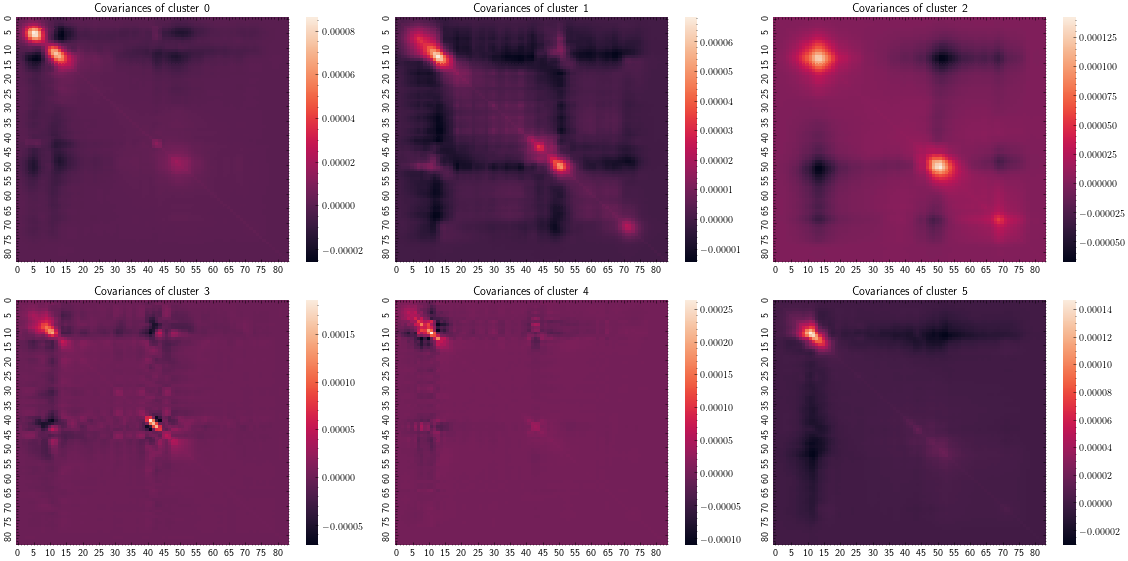

In [91]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16,8))
k = 0
for i in range(0, 2):
    for j in range(0, 3):
        sns.heatmap(covariances[k], ax=ax[i,j])
        ax[i, j].set_title(f'Covariances of cluster {k}')
        k += 1
fig.tight_layout();

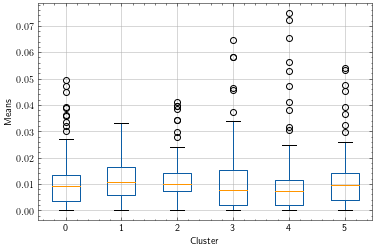

In [92]:
pd.DataFrame(means).T.boxplot()
plt.xlabel('Cluster')
plt.ylabel('Means');

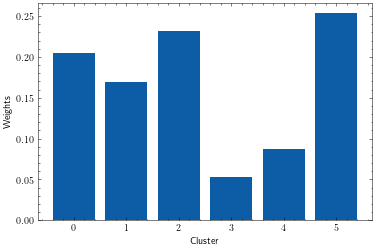

In [93]:
plt.bar(np.arange(0, n_components), weights)
plt.xlabel('Cluster')
plt.ylabel('Weights');
# plt.savefig('../reports/figures/weights.eps', dpi=300);

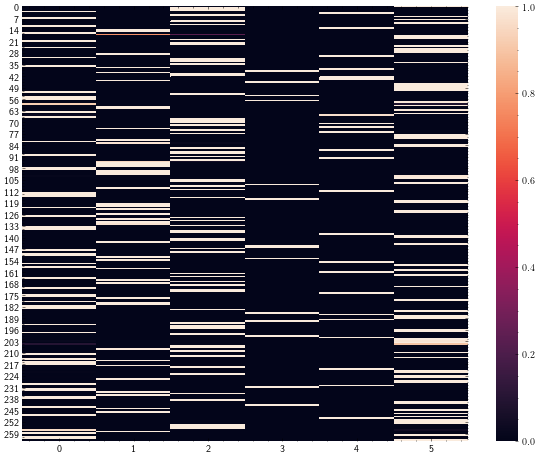

In [94]:
# In case of 6 stations the assignment of a cluster wasn't binary "enough"
fig = plt.figure(figsize=(10,8))
sns.heatmap(probs);

In [95]:
# Check where assignment of a clustrer wasn't exact (!=0 or !=1)
non_binary = []
for i in range(0, probs.shape[0]):
    for j in range(0, probs.shape[1]):
        if probs[i, j] != 1 and probs[i, j] != 0:
            non_binary.append(i)
            break

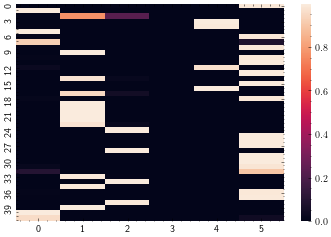

In [96]:
sns.heatmap(probs[non_binary,:]);

## 5. Visualize distance between stations by cluster 

In [5]:
entry_station_cluster = gpd.read_file('../data/interim/counts/entry_station_cluster.json')
df = pd.DataFrame(index=entry_station_cluster['station_name'].tolist(), columns=entry_station_cluster['station_name'].tolist())
df = df.fillna(0)

In [6]:
d = {}
k_max = 6
for k in range(0, k_max):
    d[k] = entry_station_cluster[entry_station_cluster['label'] == k]['station_name'].tolist()

In [7]:
df = pd.DataFrame(index=np.arange(0,6), columns=np.arange(0,6))
for i in tqdm(range(0, k_max)):
    stationsi = d[i]
    for j in range(0, k_max):
        stationsj = d[j]
        dist_list = []
        for si in stationsi:
            loni = entry_station_cluster[entry_station_cluster['station_name'] == si].loc[:, 'lon']
            lati = entry_station_cluster[entry_station_cluster['station_name'] == si].loc[:, 'lat']
            stationi = (loni, lati) 
            for sj in stationsj:
                lonj = entry_station_cluster[entry_station_cluster['station_name'] == sj].loc[:, 'lon']
                latj = entry_station_cluster[entry_station_cluster['station_name'] == sj].loc[:, 'lat']
                stationj = (lonj, latj) 
                dist = haversine(stationi, stationj)
                dist_list.append(dist)
        df.iloc[i,j] = dist_list

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:25<00:00, 24.18s/it]


In [16]:
# Decrease font size
font = {'size' : 10}
matplotlib.rc('font', **font)

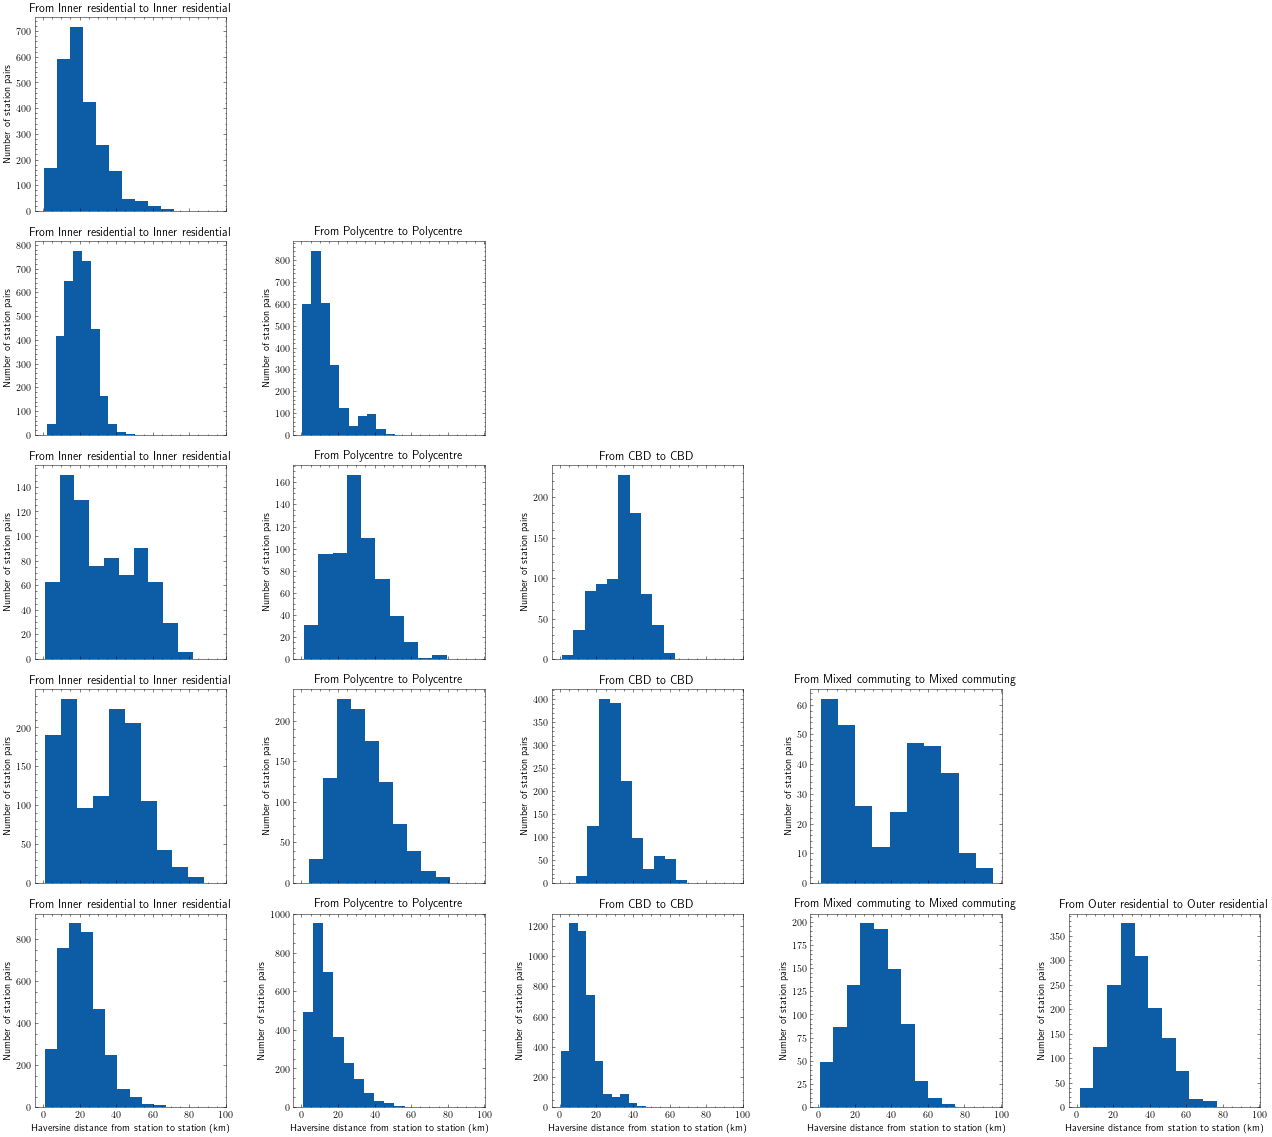

In [23]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(18,16), sharex=True)
j_max = 1

for i in range(0, 5):
    j_min = 0
    while j_min < j_max:
        ax[i, j_min].hist(df.iloc[i + 1, j_min])
        ax[i, j_min].set_title(f'From {label_names[j_min]} to {label_names[j_min]}')
        if i == 4: 
            ax[i, j_min].set_xlabel('Haversine distance from station to station (km)')
        ax[i, j_min].set_ylabel('Number of station pairs')
        j_min += 1
    j_max += 1

j_min = 0
for i in range(0, 5):
    j_max = 4
    while j_max > j_min:
        fig.delaxes(ax[i, j_max])
        j_max -= 1
    j_min += 1
    
fig.tight_layout()
plt.savefig('../figures/sfig7.png', dpi=300);